# document-clustering

Following along with Brandon Rose's document clustering tutorial on IMDB movie synopses.

https://github.com/brandomr/document_cluster/blob/master/cluster_analysis.ipynb

http://brandonrose.org/clustering

http://brandonrose.org/top100

In [1]:
%matplotlib inline

import bs4 as BeautifulSoup
import codecs
from collections import Counter
import matplotlib.pyplot as plt
import mpld3
import nltk
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
from sklearn import feature_extraction
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/home/steven/anaconda3/envs/pressbot-env/lib/python3.5/site-packages/nltk/decorators.py:59: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  regargs, varargs, varkwargs, defaults = inspect.getargspec(func)


## Getting the IMDB movie synopsis data

In [2]:
# Get top 100 movie data from IMDB
r = requests.get('http://www.imdb.com/list/ls055592025/')
soup = BeautifulSoup.BeautifulSoup(r.text, 'html.parser')
list_items = soup.findAll('div', attrs={'class': 'list_item'})

URL_BASE = 'http://www.imdb.com'
SYNOPSIS_URL = URL_BASE + '{}' + 'synopsis'   # use with .format(url) for each movie

data = []
for item in list_items:
    number = item.find('div', attrs={'class': 'number'}).text
    info = item.find('div', attrs={'class': 'info'})
    title = info.find('b').text.split('\n')[0]
    year = info.find('span', attrs={'class': 'year_type'}).text
    description = item.find('div', attrs={'class': 'item_description'}).text
    description, length = description.split('. (')[0] + '.', description.split('. (')[1][:-2]
    partial_url = info.find('b').find('a')['href']
    full_url = URL_BASE + info.find('b').find('a')['href']
    synopsis_html = requests.get(SYNOPSIS_URL.format(partial_url)).text
    synopsis_soup = BeautifulSoup.BeautifulSoup(synopsis_html, 'html.parser')
    synopsis = synopsis_soup.find('div', attrs={'id': 'swiki_body'}).text.strip()
    data.append([number, title, year, description, length, partial_url, full_url, synopsis])

In [3]:
titles = [movie[1] for movie in data]
synopses = [movie[7] for movie in data]

## Stopwords, stemming, and tokenizing
Stop words: common words that don't add to the meaning of the text

Stemming: shortening a word to it's root, so that words like "programming", "programmed", and "programs" are all the same.

Tokenizing: {{ fill info in here }}

In [4]:
# For this tutorial we'll use NLTK's stopwords, but sklearn also has a list of stopwords.
# (sklearn's list is actually longer, but includes some strange word choices like 'cry')
stopwords = nltk.corpus.stopwords.words('english')
stopwords_sklearn = feature_extraction.text.ENGLISH_STOP_WORDS

len(stopwords), len(stopwords_sklearn)

(153, 318)

In [5]:
# Load nltk's SnowballStemmer
stemmer = SnowballStemmer('english')

In [6]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_and_stem(text):
    return [stemmer.stem(t) for t in tokenize(text)]

In [7]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [8]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

## TF-IDF and Document Similarity

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                  min_df=0.2, stop_words='english',
                                  use_idf=True, tokenizer=tokenize_and_stem,
                                  ngram_range=(1,3))

In [10]:
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

In [11]:
tfidf_matrix.shape

(100, 401)

/home/steven/anaconda3/envs/pressbot-env/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/steven/anaconda3/envs/pressbot-env/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


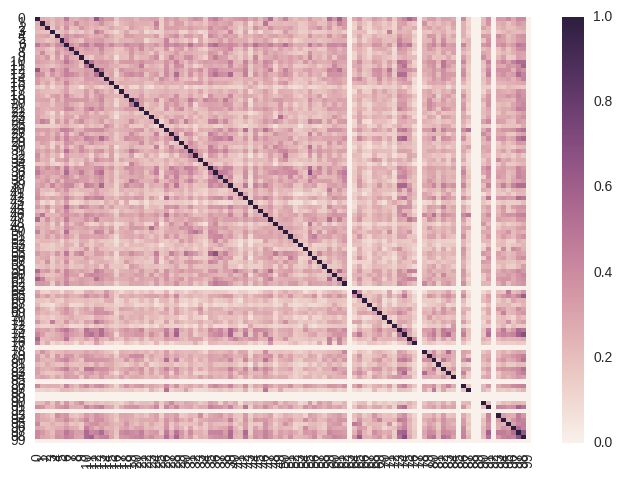

In [12]:
sns.heatmap((tfidf_matrix * tfidf_matrix.T).A)

In [13]:
terms = tfidf_vectorizer.get_feature_names()

In [14]:
dist = 1 - cosine_similarity(tfidf_matrix)

## K-means clustering

In [15]:
NUM_CLUSTERS = 5

km = KMeans(n_clusters=NUM_CLUSTERS)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [16]:
df = pd.DataFrame(data,
                     index=[clusters],
                     columns=['id',
                              'title',
                              'year',
                              'desc',
                              'length',
                              'partial_url',
                              'full_url',
                              'synopses'
                             ]
                    )
df['cluster'] = clusters

df

,id,title,year,desc,length,partial_url,full_url,synopses,cluster
4,1.,The Godfather,(1972),The aging patriarch of an organized crime dyna...,175 mins,/title/tt0068646/,http://www.imdb.com/title/tt0068646/,"In late summer 1945, guests are gathered for t...",4
4,2.,The Shawshank Redemption,(1994),Two imprisoned men bond over a number of years...,142 mins,/title/tt0111161/,http://www.imdb.com/title/tt0111161/,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4
0,3.,Schindler's List,(1993),"In German-occupied Poland during World War II,...",195 mins,/title/tt0108052/,http://www.imdb.com/title/tt0108052/,The relocation of Polish Jews from surrounding...,0
3,4.,Raging Bull,(1980),An emotionally self-destructive boxer's journe...,129 mins,/title/tt0081398/,http://www.imdb.com/title/tt0081398/,"The film opens in 1964, where an older and fat...",3
0,5.,Casablanca,(1942),"In Casablanca, Morocco in December 1941, a cyn...",102 mins,/title/tt0034583/,http://www.imdb.com/title/tt0034583/,"In the early years of World War II, December 1...",0
4,6.,Citizen Kane,(1941),"Following the death of a publishing tycoon, ne...",119 mins,/title/tt0033467/,http://www.imdb.com/title/tt0033467/,"It's 1941, and newspaper tycoon Charles Foster...",4
4,7.,Gone with the Wind,(1939),A manipulative Southern belle carries on a tur...,238 mins,/title/tt0031381/,http://www.imdb.com/title/tt0031381/,"The film opens in Tara, a cotton plantation ow...",4
4,8.,The Wizard of Oz,(1939),Dorothy Gale is swept away to a magical land i...,102 mins,/title/tt0032138/,http://www.imdb.com/title/tt0032138/,Dorothy Gale (Judy Garland) is an orphaned tee...,4
0,9.,One Flew Over the Cuckoo's Nest,(1975),A criminal pleads insanity after getting into ...,133 mins,/title/tt0073486/,http://www.imdb.com/title/tt0073486/,"In 1963 Oregon, Randle Patrick McMurphy (Nicho...",0
0,10.,Lawrence of Arabia,(1962),"The story of T.E. Lawrence, the English office...",216 mins,/title/tt0056172/,http://www.imdb.com/title/tt0056172/,"In 1935, T. E. Lawrence (Peter O'Toole) is kil...",0


In [17]:
df['cluster'].value_counts()

4    45
0    22
2    18
3     9
1     6
Name: cluster, dtype: int64

In [18]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

"""for i in range(len(clusters)):
    print "Cluster {} words".format(i)
    
    for ind in order_centroids[i, :6]:
        part1 = vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]
        part2 = part1.encode('utf-8', 'ignore')
        print '{}'.format(part2)"""

'for i in range(len(clusters)):\n    print "Cluster {} words".format(i)\n    \n    for ind in order_centroids[i, :6]:\n        part1 = vocab_frame.ix[terms[ind].split(\' \')].values.tolist()[0][0]\n        part2 = part1.encode(\'utf-8\', \'ignore\')\n        print \'{}\'.format(part2)'

In [19]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(NUM_CLUSTERS):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in df.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'command', b'soldier', b'order', b'armi', b'offic', b'men',

Cluster 0 titles: Schindler's List, Casablanca, One Flew Over the Cuckoo's Nest, Lawrence of Arabia, Star Wars: Episode IV - A New Hope, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, Titanic, From Here to Eternity, Saving Private Ryan, Raiders of the Lost Ark, Patton, Jaws, The Good, the Bad and the Ugly, Platoon, Dances with Wolves, Jurassic Park, The Deer Hunter, The Great Dictator,

Cluster 1 words: b'father', b'polic', b'brother', b'car', b'becom', b'mother',

Cluster 1 titles: The Sound of Music, Braveheart, Goodfellas, Bonnie and Clyde, Rain Man, Rebel Without a Cause,

Cluster 2 words: b'film', b'girl', b'relationship', b'love', b'warn', b'father',

Cluster 2 titles: Sunset Blvd., Forrest Gump, Singin' in the Rain, Amadeus, An American in Paris, The Tr

In [20]:
frame = df
frame['rank'] = frame['id']

In [21]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'].str.replace('.', '').astype(int) + 1
frame['Title'] = frame['title']

In [22]:
#export tables to HTML
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rank</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>18</td>
      <td>The Sound of Music</td>
    </tr>
    <tr>
      <td>52</td>
      <td>Braveheart</td>
    </tr>
    <tr>
      <td>63</td>
      <td>Goodfellas</td>
    </tr>
    <tr>
      <td>66</td>
      <td>Bonnie and Clyde</td>
    </tr>
    <tr>
      <td>73</td>
      <td>Rain Man</td>
    </tr>
    <tr>
      <td>97</td>
      <td>Rebel Without a Cause</td>
    </tr>
  </tbody>
</table>


In [23]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [24]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [25]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

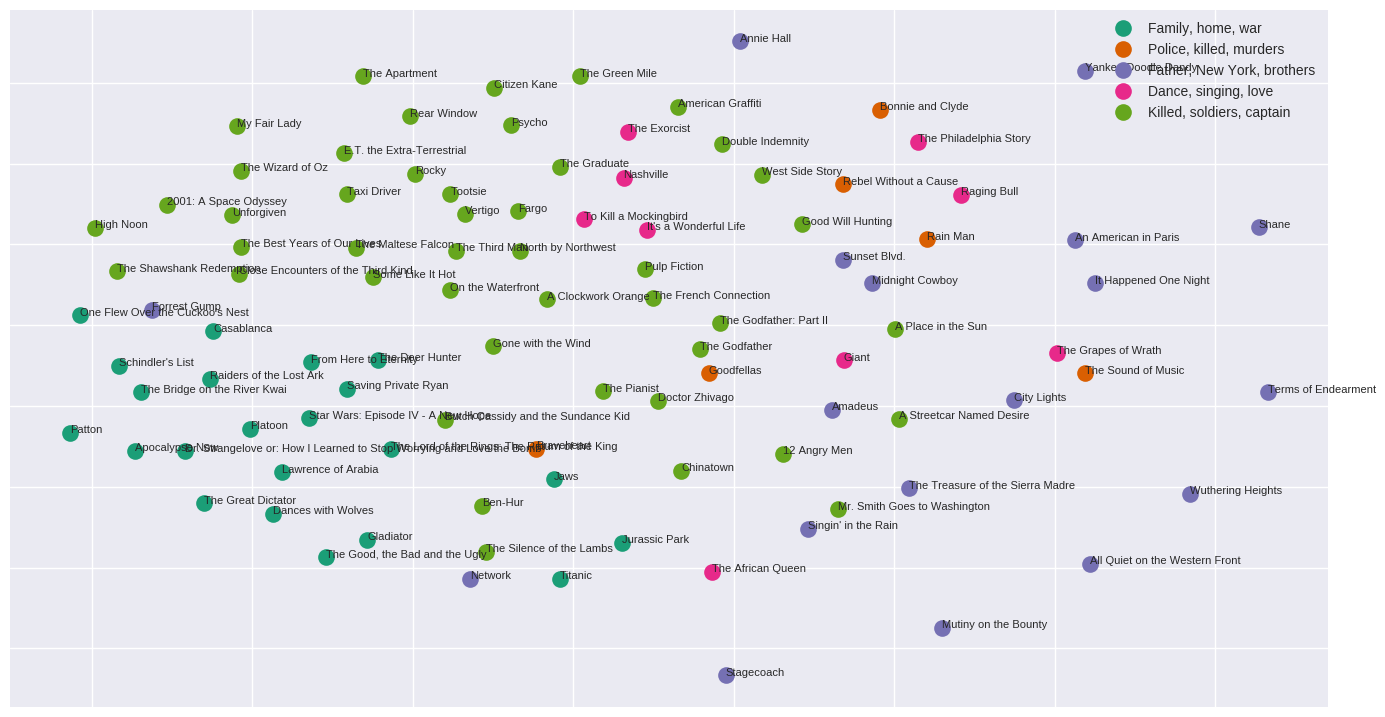

In [26]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [27]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [28]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

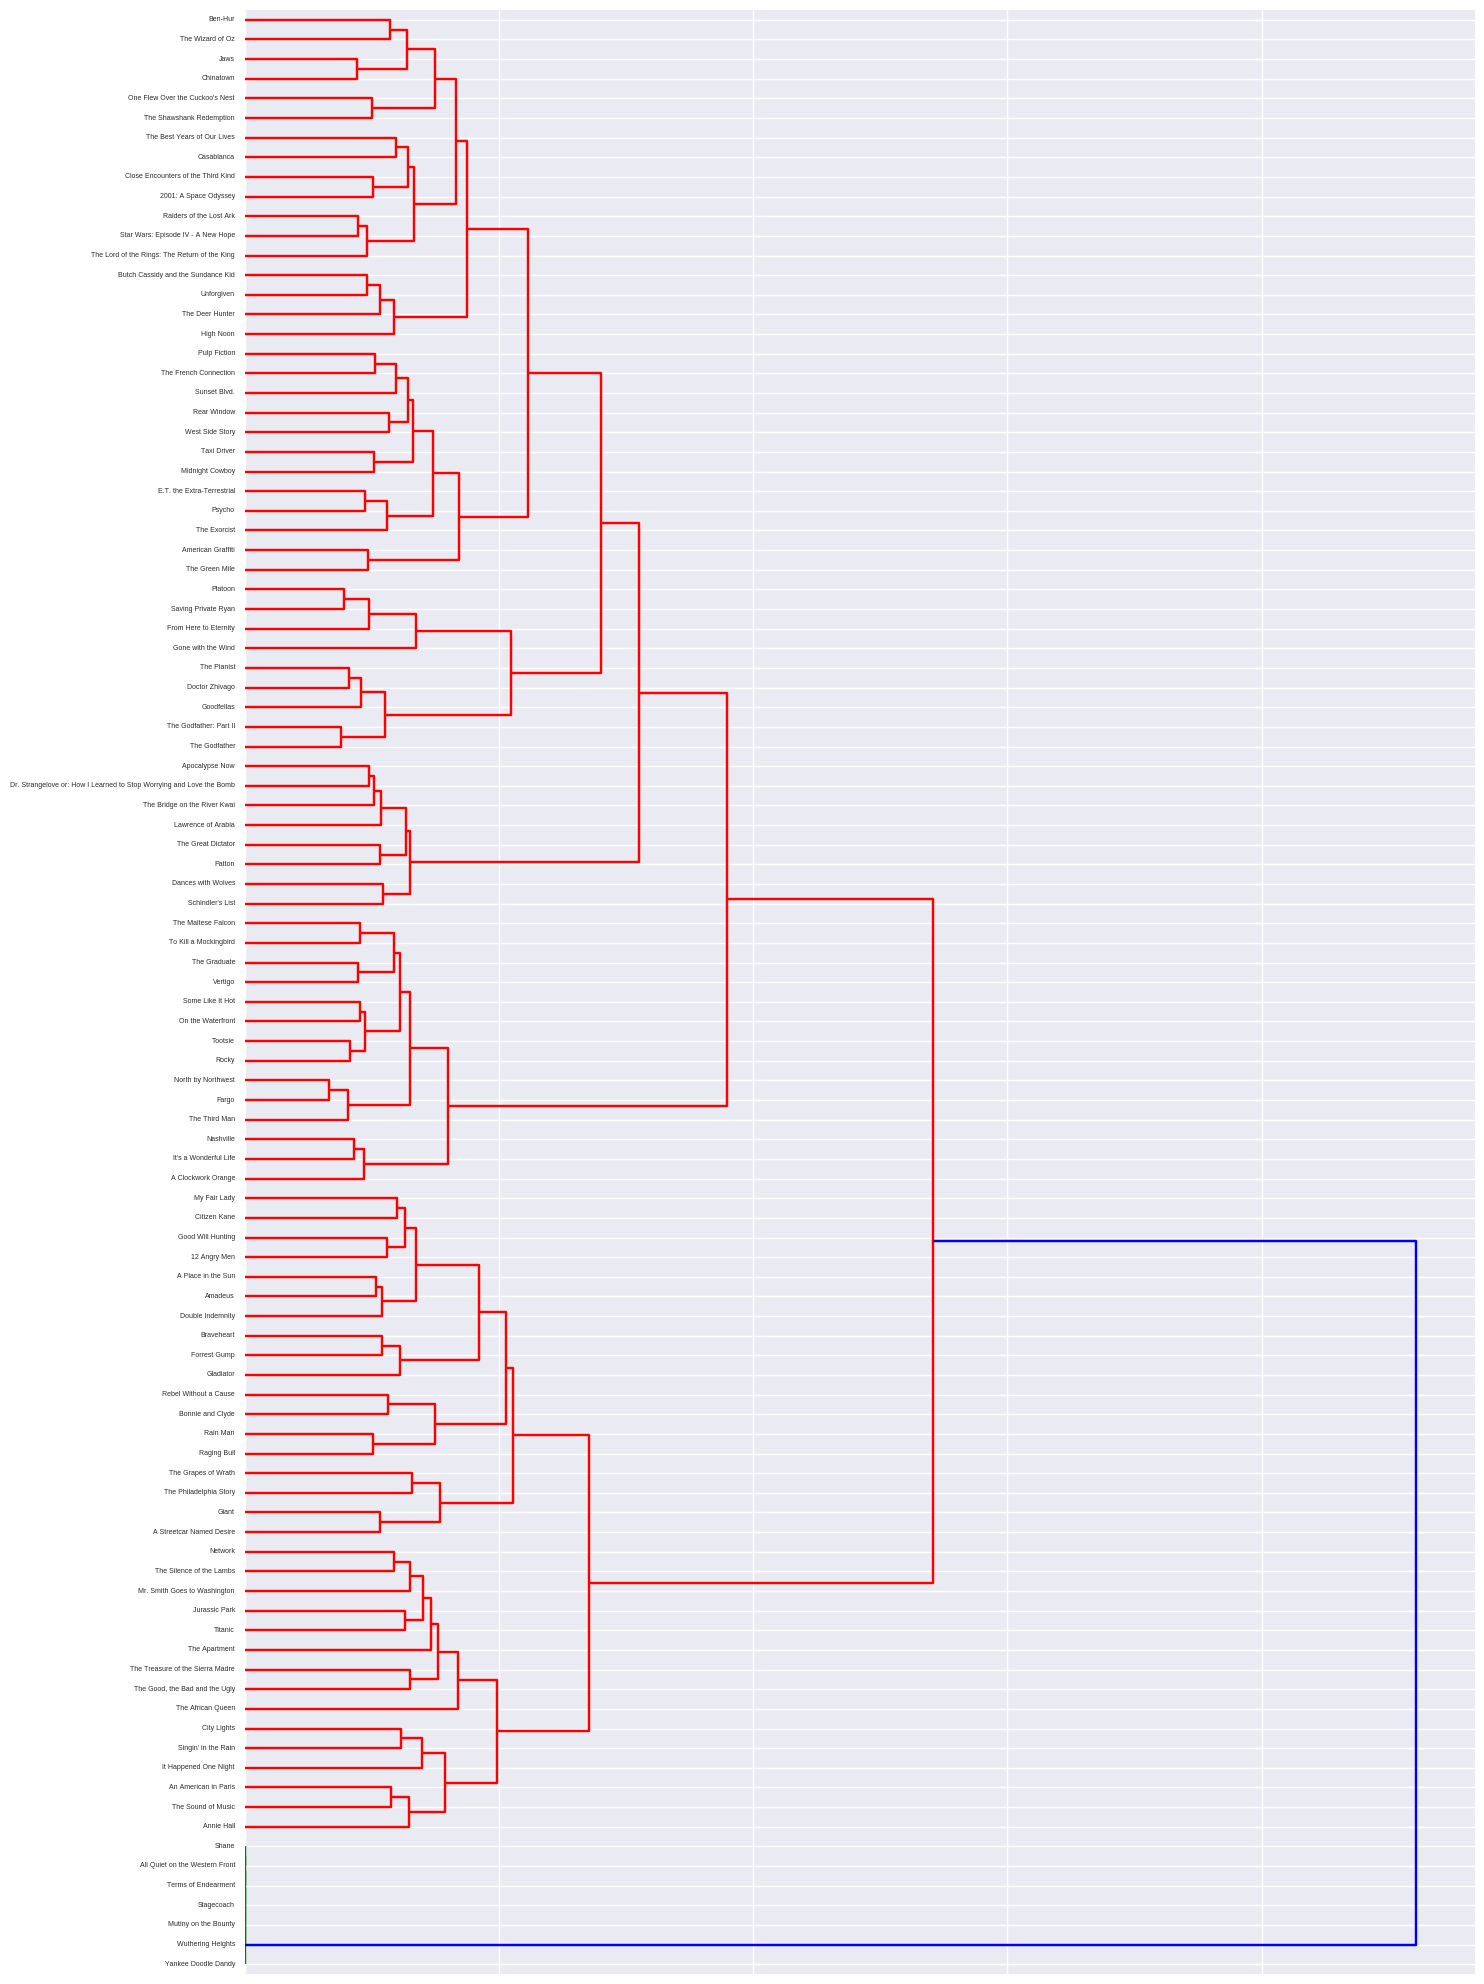

In [29]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [30]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [31]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [32]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

/home/steven/anaconda3/envs/pressbot-env/lib/python3.5/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)


CPU times: user 6.09 s, sys: 35 µs, total: 6.09 s
Wall time: 6.09 s
CPU times: user 360 ms, sys: 0 ns, total: 360 ms
Wall time: 360 ms


In [33]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1283


In [39]:
dictionary = corpora.Dictionary(texts)

In [40]:
dictionary.filter_extremes(no_below=1, no_above=0.8)

In [41]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [42]:
len(corpus)

100

In [43]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 7min 38s, sys: 556 ms, total: 7min 38s
Wall time: 7min 39s


In [44]:
print(lda[corpus[0]])

[(2, 0.99931950389466795)]


In [45]:
topics = lda.print_topics(5, num_words=20)

In [46]:
topics

[(0,
  "0.006*kill + 0.005*men + 0.005*tell + 0.005*man + 0.005*find + 0.004*go + 0.004*back + 0.004*see + 0.004*arriv + 0.004*get + 0.004*befor + 0.004*two + 0.004*day + 0.004*say + 0.004*soldier + 0.004*tri + 0.004*ask + 0.004*make + 0.004*shark + 0.003*n't"),
 (1,
  "0.008*tell + 0.005*get + 0.005*n't + 0.005*find + 0.005*back + 0.004*man + 0.004*two + 0.004*return + 0.004*ask + 0.004*go + 0.004*see + 0.004*say + 0.004*come + 0.004*time + 0.004*away + 0.004*hous + 0.003*car + 0.003*doe + 0.003*make + 0.003*tri"),
 (2,
  '0.009*famili + 0.007*father + 0.007*tell + 0.006*meet + 0.005*brother + 0.005*kill + 0.004*fight + 0.004*man + 0.003*find + 0.003*also + 0.003*return + 0.003*son + 0.003*tri + 0.003*arriv + 0.003*men + 0.003*refus + 0.003*year + 0.003*polic + 0.003*never + 0.003*back'),
 (3,
  "0.016*tell + 0.009*get + 0.007*car + 0.007*back + 0.007*see + 0.006*n't + 0.005*go + 0.005*ask + 0.005*man + 0.005*call + 0.005*talk + 0.005*goe + 0.004*look + 0.004*begin + 0.004*say + 0.004

### Sklearn Tutorial on Clustering
http://scikit-learn.org/stable/auto_examples/text/document_clustering.html